In [17]:
## Version futuresales lib required = 0.2.0

!pip install -i https://test.pypi.org/simple/ futuresales_denissimo==0.2.0
# !pip install plotly==5.3.1
# !pip install neptune-client
# !pip install neptune-sklearn

Looking in indexes: https://test.pypi.org/simple/


In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

import futuresales as fs

from futuresales.distribution import from_pickle, to_pickle
from futuresales.utils import make_scaled, load_credentials
from futuresales.validation import Validator, make_hpo_dataset, get_statistics

from neptune.new.types import File

# Base neptune configuration

In [19]:
import neptune.new as neptune

cred = load_credentials('../../credentials.json')['projects']['fs-results']

# run = neptune.init(
#     api_token=cred['api_token'],
#     project=cred['project'],
#     tags=['linear', 'baseline', 'boruta', 'one-spike'],
# )  # your credentials

# Dataset preparation

In [20]:
task_df = {}

task_df['test'] = pd.read_csv('../../tmp/task_df_test.csv')
task_df['train'] = pd.read_csv('../../tmp/task_df_train.csv')
task_df['idx'] = pd.read_csv('../../tmp/idx.csv')

train = pd.read_csv('../../tmp/baseline_train_set.csv')
test = pd.read_csv('../../tmp/baseline_test_set.csv')
validation = pd.read_csv('../../tmp/baseline_validation_set.csv')

selector = from_pickle('../../tmp/feat_selector.pkl')

/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [21]:
serieses = task_df['test'].groupby(['month_block', 'id']).item_cnt_day.sum().reset_index().set_index('id').index.value_counts()

In [22]:
train_objs = serieses[serieses > 1].index

In [23]:
train_x = train[train.id.isin(train_objs)].drop(['valid_target', 'target'], axis=1)
train_y = train[train.id.isin(train_objs)].loc[:, ['target']]
train_y_valid = train[train.id.isin(train_objs)].loc[:, ['valid_target']]

test_x = test[test.id.isin(train_objs)].drop(['valid_target', 'target'], axis=1)
test_y = test[test.id.isin(train_objs)].loc[:, ['target']]
test_y_valid = test[test.id.isin(train_objs)].loc[:, ['valid_target']]

validation_x = validation.drop(['valid_target', 'target'], axis=1)
validation_y = validation.loc[:, ['target']]
validation_y_valid = validation.loc[:, ['valid_target']]

train_x = make_scaled(train_x).drop('id', axis=1).reset_index().rename({'index': 'id'}, axis=1).set_index('id')
test_x = make_scaled(test_x).drop('id', axis=1).reset_index().rename({'index': 'id'}, axis=1).set_index('id')
validation_x = make_scaled(validation_x).drop('id', axis=1).reset_index().rename({'index': 'id'}, axis=1).set_index('id')

In [24]:
train_x = train_x.loc[:, selector.support_].reset_index().rename({'index': 'id'},axis=1).merge(task_df['idx'][['shop_id', 'item_id', 'id']], on='id').set_index('id')
test_x = test_x.loc[:,selector.support_].reset_index().rename({'index': 'id'},axis=1).merge(task_df['idx'][['shop_id', 'item_id', 'id']], on='id').set_index('id')
validation_x = validation_x.loc[:,selector.support_].reset_index().rename({'index': 'id'},axis=1).merge(task_df['idx'][['shop_id', 'item_id', 'id']], on='id').set_index('id')

# Model tuning

In [25]:
# define a search space
from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet
import seaborn as sns
from futuresales.utils import hyperopt_objective
from hyperopt import hp
from hyperopt import fmin, tpe, Trials

searching_space = {
    'alpha': hp.loguniform('alpha', 0, 25)
}

trials = Trials()
ridge_obj = hyperopt_objective(
    Ridge,
    (train_x, train_y),
    (test_x, test_y)
)

# ridge_obj({'alpha': 1e-7})

# minimize the objective over the space
hpo = trials.fmin(ridge_obj, searching_space, algo=tpe.suggest, max_evals=100)

In [27]:
hpo_df, min_hyp = make_hpo_dataset(trials)

In [28]:
hpo_df

,alpha,loss_type,loss
0,1.862597e+06,test,5.644144
1,1.862597e+06,train,1.216892
2,4.720520e+10,test,5.890366
3,4.720520e+10,train,1.883267
4,3.026272e+04,test,5.517410
...,...,...,...
195,1.484377e+01,train,1.036967
196,1.660404e+02,test,5.500520
197,1.660404e+02,train,1.036969
198,3.886990e+02,test,5.500674


In [29]:
# run['hpo'] = {
#     'min_params': hpo,
#     'trials': File.as_html(hpo_df),
#     'trials_pkl': File.as_pickle(hpo_df),
#     'cross-dependency': File.as_image(sns.pairplot(data=hpo_df, hue='loss_type').figure)
# }

In [30]:
errors = {}

In [31]:
assert False

AssertionError: 

In [ ]:
lin_validator = Validator(Ridge, **hpo)

lin_validator.fit(test_x, test_y)
errors['ridge'] = lin_validator.validate(validation_x, validation_y_valid)
residulas = get_statistics(errors['ridge'])

run['params'] = min_hyp

run['score/rmse/test'] = errors['ridge'][0]
run['score/rmse/train'] = errors['ridge'][1]
run['model'] = 'Ridge'
run['dump/residuals'].upload(File.as_pickle(residulas))
run['dump/model'].upload(File.as_pickle(lin_validator))

/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


Did not log prediction error chart. Error: y must be a (1,) dimensional array not (422577, 1)
Did not log cooks distance chart. Error: shapes (422577,1) and (422577,1) not aligned: 1 (dim 1) != 422577 (dim 0)


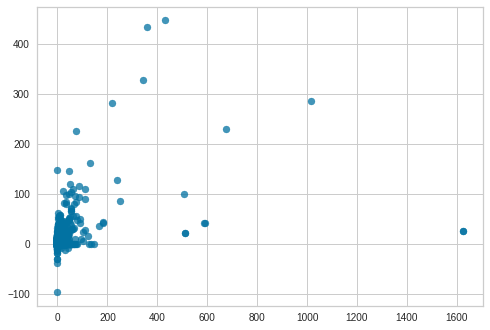

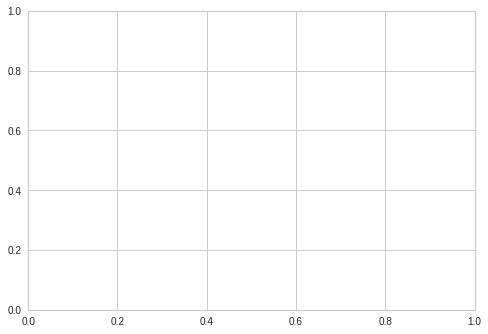

In [ ]:
import neptune.new.integrations.sklearn as npt_utils

run['auto_model_summary'] = npt_utils.create_regressor_summary(
    lin_validator.model, 
    train_x, 
    test_x, 
    train_y.to_numpy(), 
    test_y_valid.to_numpy())

In [ ]:
run.stop()